### Import and Install all Dependencied

In [4]:
!pip install gradio mediapipe opencv-python matplotlib
#download and install mediapipe and gradio

In [2]:
import cv2
import mediapipe as mp
import numpy as np

## Open cv feed

In [3]:
cap=cv2.VideoCapture(0)  #video capture 
while cap.isOpened():  #looping through our webcam
    ret,frame=cap.read() # reading the feed as our webcam is going throght each frame
    
    cv2.imshow('Selfie Seg',frame)


#exiting throug our webcam
    if cv2.waitKey(10) & 0xFF==ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

## Apply Selfie Segmentation

In [4]:
mp_selfie=mp.solutions.selfie_segmentation
#initiate our selfie module and hold it

In [5]:
cap=cv2.VideoCapture(0)
#create with statement for model

with mp_selfie.SelfieSegmentation(model_selection=0) as model:
    while cap.isOpened():
        ret,frame=cap.read()

        #apply segmentation
        frame.flags.writeable=False
        frame=cv2.cvtColor(frame,cv2.COLOR_BGR2RGB) #recolor our  i.e inorder to pass the model all the bgr is converted to rgb
        res=model.process(frame)
        frame.flags.writeable=True
        # this is not actully rendered we will achieve this inside our gradio app

        
        cv2.imshow('Selfie Seg',frame)

        if cv2.waitKey(10) & 0xFF==ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

In [5]:
res.segmentation_mask


array([[1.3807978e-32, 1.2427181e-32, 6.9039891e-33, ..., 3.3767487e-38,
        6.7534991e-39, 0.0000000e+00],
       [9.9628541e-26, 8.9665684e-26, 4.9814270e-26, ..., 1.3157421e-29,
        2.6314855e-30, 0.0000000e+00],
       [2.7674591e-25, 2.4907132e-25, 1.3837296e-25, ..., 3.6548391e-29,
        7.3096813e-30, 0.0000000e+00],
       ...,
       [4.1233389e-17, 3.7110049e-17, 2.0616694e-17, ..., 4.8084155e-01,
        5.0248796e-01, 5.0789952e-01],
       [1.7318023e-16, 1.5586220e-16, 8.6590114e-17, ..., 4.7797203e-01,
        5.0223517e-01, 5.0830090e-01],
       [2.4740032e-16, 2.2266029e-16, 1.2370016e-16, ..., 4.7635794e-01,
        5.0209296e-01, 5.0852668e-01]], dtype=float32)

## Process Results

In [6]:
from matplotlib import pyplot as plt
from matplotlib import gridspec

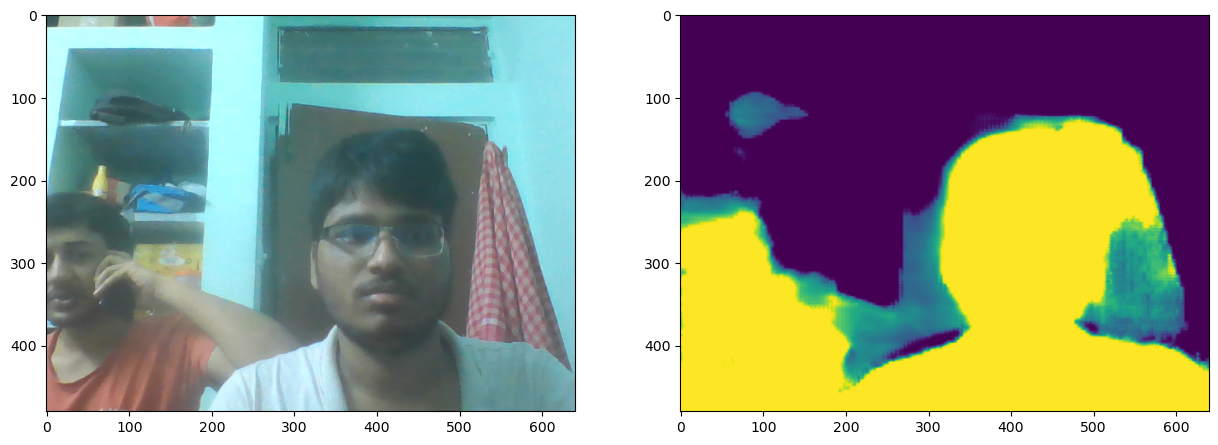

In [7]:
#layout
plt.figure(figsize=(15,15))  #this basically specifies how big our end plot will be i.e of size 15*15
grid=gridspec.GridSpec(1,2)  # for our grid we will be having one row and 2 columns i.e one image inside of each column


#setup our axes
ax0=plt.subplot(grid[0]) # here we have passed our first variable into our first grid column 
ax1=plt.subplot(grid[1])  #here we have passed our second variable into second grid column

ax0.imshow(frame)
ax1.imshow(res.segmentation_mask)

plt.show()


In [8]:
#now we will start extracting different components from that image
backgroud=np.zeros(frame.shape,dtype=np.uint8)   # we are creating a black background the dtype here is integer as when we apply our logic we need to set it into integer
mask=np.stack((res.segmentation_mask,)*3,axis=-1)>0.5  # now we are stacking it and putting the channel at last and only return results which are greater than 0.5(also known as setting up of the probabilty component greater than 50%)


In [9]:
#backgroud=np.ones(frame.shape)

In [10]:
#for example#remember 0=black and 1=white
#np.zeros((10,10)) #a 10*10 array of 0
#np.zeros(frame.shape) #a frame which is made of array which in turn made up of 0s
#plt.imshow(np.zeros(frame.shape)) #a black backgroud 
#plt.imshow(np.ones(frame.shape)) #a white background


In [11]:
#creating a stack array
#np.array((res.segmentation_mask,)*3).shape # this code creates 3 different channels
#np.stack((res.segmentation_mask,)*3,axis=-1).shape # now we are stacking it and putting the channel at last

In [9]:
segmentated_image=np.where(mask,frame,backgroud) # this returns value say is true then returns value from the frame which is captured from the cam else return black

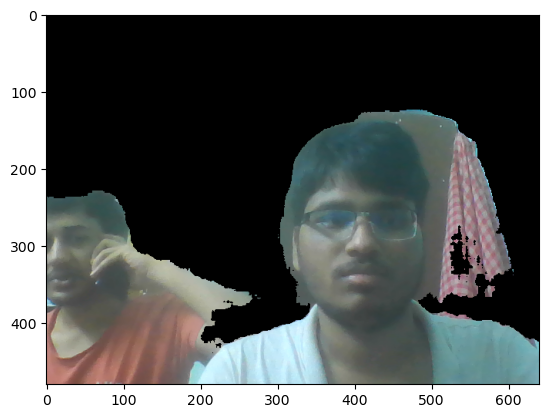

In [10]:
plt.imshow(segmentated_image)


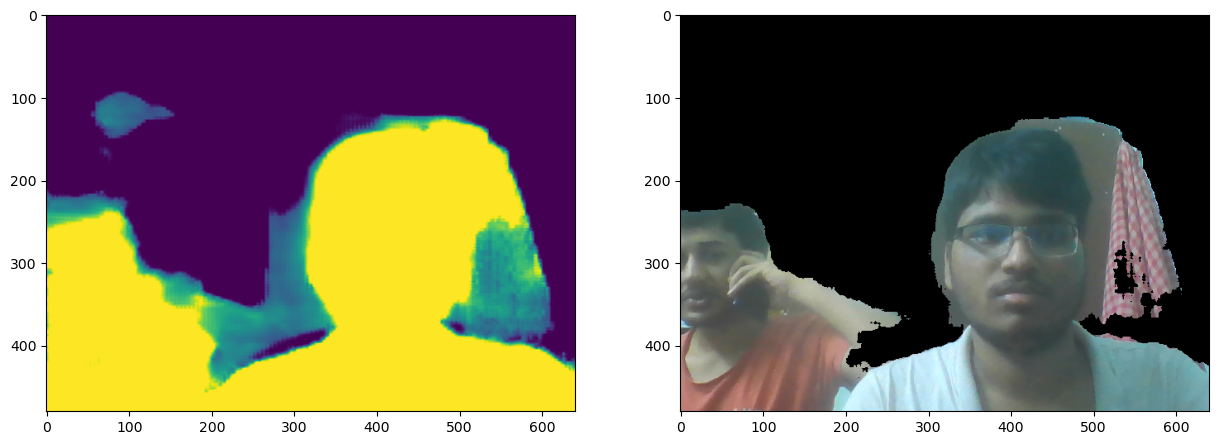

In [11]:
#layout
plt.figure(figsize=(15,15))  #this basically specifies how big our end plot will be i.e of size 15*15
grid=gridspec.GridSpec(1,2)  # for our grid we will be having one row and 2 columns i.e one image inside of each column


#setup our axes
ax0=plt.subplot(grid[0]) # here we have passed our first variable into our first grid column 
ax1=plt.subplot(grid[1])  #here we have passed our second variable into second grid column

ax0.imshow(res.segmentation_mask)
ax1.imshow(segmentated_image)

plt.show()

In [12]:
# how we will replace our black backgroung with something nicer
# so will just blur the background
segmentated_image=np.where(mask,frame,cv2.blur(frame,(40,40))) # we replaced the backgroud with blurred background




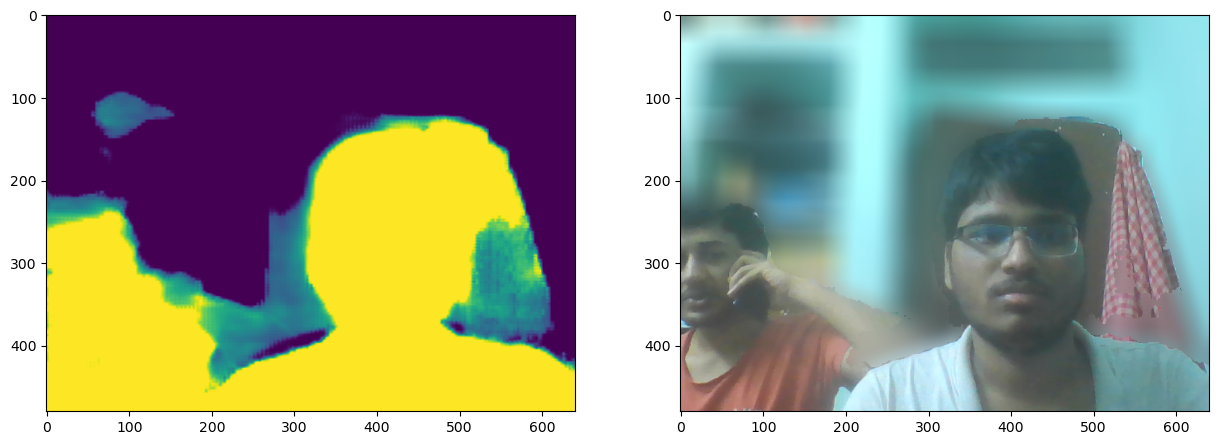

In [13]:
#layout
plt.figure(figsize=(15,15))  #this basically specifies how big our end plot will be i.e of size 15*15
grid=gridspec.GridSpec(1,2)  # for our grid we will be having one row and 2 columns i.e one image inside of each column


#setup our axes
ax0=plt.subplot(grid[0]) # here we have passed our first variable into our first grid column 
ax1=plt.subplot(grid[1])  #here we have passed our second variable into second grid column

ax0.imshow(res.segmentation_mask)
ax1.imshow(segmentated_image)

plt.show()

## Wrapping in Gradio app

In [14]:
import gradio as gr

In [15]:
# we will be encapsulating all this inside a function
# the input image will be passed through the gradio app
# all the codes inside the function is pretty much the same as above
def segment(image):
    with mp_selfie.SelfieSegmentation(model_selection=0) as model:
        res=model.process(image)
        mask=np.stack((res.segmentation_mask,)*3,axis=-1)>0.5
        return np.where(mask,image,cv2.blur(image,(40,40)))

In [16]:
# now we will capture our feed from the gradio app through the webcam
try:
    webcam=gr.inputs.Image(shape=(640,480),source="webcam")
except AttributeError:
    print("No such attribute")

d:\anaconda\lib\site-packages\gradio\inputs.py:259: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
d:\anaconda\lib\site-packages\gradio\inputs.py:262: UserWarning: `optional` parameter is deprecated, and it has no effect
  super().__init__(


In [17]:
# creating our gradio interface
#the interface module takes up 3 arguements i.e function,inputs,and outputs 
webapp=gr.interface.Interface(fn=segment,inputs=webcam,outputs="image")

## Launching the Webapp

In [18]:
webapp.launch(share=True)

Running on local URL:  http://127.0.0.1:7860

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app. 

Also please ensure that your antivirus or firewall is not blocking the binary file located at: d:\anaconda\lib\site-packages\gradio\frpc_windows_amd64_v0.2
